In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

data = pd.read_csv('fashion-mnist_train.csv')
from sklearn.model_selection import train_test_split

# Split data into 80% train and 20% validation
train_data, validation_data = train_test_split(data, test_size=0.2, random_state=42)

train_data = np.array(train_data)
m,n = train_data.shape
train_data = train_data.T
Y_train = train_data[0]
X_train = train_data[1:m]
X_train = X_train / 255
print(X_train.shape)

validation_data = np.array(validation_data)
validation_data = validation_data.T
Y_valid = validation_data[0]
X_valid = validation_data[1:]
X_valid = X_valid / 255
print(X_valid.shape)

test_data = pd.read_csv('fashion-mnist_test.csv')
test_data = np.array(test_data)
test_data = test_data.T
Y_test = test_data[0]
X_test = test_data[1:]
X_test = X_test / 255
print(X_test.shape)
# p1 , p2 , p3 , ... 

(784, 48000)
(784, 12000)
(784, 10000)


In [2]:
import numpy as np
import seaborn as sns
from sklearn.metrics import f1_score


class NeuralNetwork:
    def __init__(self, input_size=784, hidden_size=10, output_size=10, alpha=0.01):
        # Initialize weights and biases
        self.W1 = np.random.rand(hidden_size, input_size) - 0.5
        self.b1 = np.random.rand(hidden_size, 1) - 0.5
        self.W2 = np.random.rand(output_size, hidden_size) - 0.5
        self.b2 = np.random.rand(output_size, 1) - 0.5
        self.alpha = alpha

        # Initialize moment and velocity estimates for Adam optimization
        self.mW1 = np.zeros_like(self.W1)
        self.mb1 = np.zeros_like(self.b1)
        self.mW2 = np.zeros_like(self.W2)
        self.mb2 = np.zeros_like(self.b2)
        self.vW1 = np.zeros_like(self.W1)
        self.vb1 = np.zeros_like(self.b1)
        self.vW2 = np.zeros_like(self.W2)
        self.vb2 = np.zeros_like(self.b2)
        
        # Hyperparameters for Adam
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

    def ReLU(self, Z):
        return np.maximum(Z, 0)
    
    def ReLU_deriv(self, Z):
        return Z > 0

    def softmax(self, Z):
        Z_max = np.max(Z, axis=0, keepdims=True)
        Z = Z - Z_max
        exp_Z = np.exp(Z)
        sum_exp_Z = np.sum(exp_Z, axis=0, keepdims=True)
        return exp_Z / (sum_exp_Z + self.epsilon)
    
    def forward_prop(self, X, dropout_rate=0.2, training=True):
        Z1 = self.W1.dot(X) + self.b1
        A1 = self.ReLU(Z1)
        
        if training and dropout_rate > 0:
            mask = np.random.rand(*A1.shape) < (1 - dropout_rate)
            A1 *= mask
            A1 /= (1 - dropout_rate) + self.epsilon
        
        Z2 = self.W2.dot(A1) + self.b2
        A2 = self.softmax(Z2)
        return Z1, A1, Z2, A2

    def one_hot(self, Y):
        one_hot_Y = np.zeros((Y.size, Y.max() + 1))
        one_hot_Y[np.arange(Y.size), Y] = 1
        return one_hot_Y.T

    def backward_prop(self, Z1, A1, Z2, A2, X, Y):
        one_hot_Y = self.one_hot(Y)
        dZ2 = A2 - one_hot_Y
        dW2 = 1 / X.shape[1] * dZ2.dot(A1.T)
        db2 = 1 / X.shape[1] * np.sum(dZ2)
        dZ1 = self.W2.T.dot(dZ2) * self.ReLU_deriv(Z1)
        dW1 = 1 / X.shape[1] * dZ1.dot(X.T)
        db1 = 1 / X.shape[1] * np.sum(dZ1)
        return dW1, db1, dW2, db2

    def update_params(self, dW1, db1, dW2, db2, t):
        self.mW1 = self.beta1 * self.mW1 + (1 - self.beta1) * dW1
        self.mb1 = self.beta1 * self.mb1 + (1 - self.beta1) * db1
        self.mW2 = self.beta1 * self.mW2 + (1 - self.beta1) * dW2
        self.mb2 = self.beta1 * self.mb2 + (1 - self.beta1) * db2

        self.vW1 = self.beta2 * self.vW1 + (1 - self.beta2) * (dW1 ** 2)
        self.vb1 = self.beta2 * self.vb1 + (1 - self.beta2) * (db1 ** 2)
        self.vW2 = self.beta2 * self.vW2 + (1 - self.beta2) * (dW2 ** 2)
        self.vb2 = self.beta2 * self.vb2 + (1 - self.beta2) * (db2 ** 2)

        mW1_hat = self.mW1 / (1 - self.beta1 ** t + self.epsilon)
        mb1_hat = self.mb1 / (1 - self.beta1 ** t + self.epsilon)
        mW2_hat = self.mW2 / (1 - self.beta1 ** t + self.epsilon)
        mb2_hat = self.mb2 / (1 - self.beta1 ** t + self.epsilon)
        vW1_hat = self.vW1 / (1 - self.beta2 ** t + self.epsilon)
        vb1_hat = self.vb1 / (1 - self.beta2 ** t + self.epsilon)
        vW2_hat = self.vW2 / (1 - self.beta2 ** t + self.epsilon)
        vb2_hat = self.vb2 / (1 - self.beta2 ** t + self.epsilon)

        self.W1 -= self.alpha * mW1_hat / (np.sqrt(vW1_hat) + self.epsilon)
        self.b1 -= self.alpha * mb1_hat / (np.sqrt(vb1_hat) + self.epsilon)
        self.W2 -= self.alpha * mW2_hat / (np.sqrt(vW2_hat) + self.epsilon)
        self.b2 -= self.alpha * mb2_hat / (np.sqrt(vb2_hat) + self.epsilon)

    def get_predictions(self, A2):
        return np.argmax(A2, 0)

    def get_accuracy(self, predictions, Y):
        return np.sum(predictions == Y) / Y.size

    def gradient_descent(self, X, Y, iterations):
        for i in range(iterations):
            Z1, A1, Z2, A2 = self.forward_prop(X)
            dW1, db1, dW2, db2 = self.backward_prop(Z1, A1, Z2, A2, X, Y)
            self.update_params(dW1, db1, dW2, db2, t=i+1)

    def get_loss(self, predictions, Y):
        m = Y.size
        one_hot_Y = self.one_hot(Y)
        loss = -np.sum(one_hot_Y * np.log(predictions + self.epsilon)) / m
        return loss
    
    def get_f1_score(self, predictions, Y):
        f1 = f1_score(Y, predictions, average="macro")
        return f1
    
    def make_predictions(self, X):
        _, _, _, A2 = self.forward_prop(X, dropout_rate=0, training=False)
        predictions = self.get_predictions(A2)
        return predictions
    
    def get_probabilities(self,X):
        _, _, _, A2 = self.forward_prop(X, dropout_rate=0, training=False)
        return A2
    
    def train_and_record_metrics(self, X, Y, X_val, Y_val, iterations):
        # Lists to store metrics at each iteration
        accuracy_list = []
        loss_list = []
        f1_score_list = []

        for i in range(1, iterations + 1):
            # Perform one step of gradient descent
            Z1, A1, Z2, A2 = self.forward_prop(X)
            dW1, db1, dW2, db2 = self.backward_prop(Z1, A1, Z2, A2, X, Y)
            self.update_params(dW1, db1, dW2, db2, t=i)

            # Get predictions and calculate metrics on validation set
            val_probabilities = self.get_probabilities(X_val)
            val_predictions = self.make_predictions(X_val)

            accuracy = self.get_accuracy(val_predictions, Y_val)
            loss = self.get_loss(val_probabilities, Y_val)
            f1 = self.get_f1_score(val_predictions, Y_val)

            # Store metrics
            accuracy_list.append(accuracy)
            loss_list.append(loss)
            f1_score_list.append(f1)

        # Plot metrics
        print(accuracy_list[-1],loss_list[-1],f1_score_list[-1])
        self.plot_metrics(accuracy_list, loss_list, f1_score_list, iterations)
        predictions = self.make_predictions(X_val)
        cm = self.get_confusion_matrix(Y_val,predictions)
        class_labels = [0,1,2,3,4,5,6,7,8,9]
        self.plot_confusion_matrix(cm,class_labels)

    def plot_metrics(self, accuracy_list, loss_list, f1_score_list, iterations):
        # Plot Accuracy vs Iterations
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(range(1, iterations + 1), accuracy_list, label="Accuracy", color="blue")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs Iterations")

        # Plot Loss vs Iterations
        plt.subplot(1, 3, 2)
        plt.plot(range(1, iterations + 1), loss_list, label="Loss", color="red")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.title("Loss vs Iterations")

        # Plot F1-Score vs Iterations
        plt.subplot(1, 3, 3)
        plt.plot(range(1, iterations + 1), f1_score_list, label="F1 Score", color="green")
        plt.xlabel("Iterations")
        plt.ylabel("F1 Score")
        plt.title("F1 Score vs Iterations")

        plt.tight_layout()
        plt.show()
    
    def get_confusion_matrix(self,y_true, y_pred):
    
        classes = np.unique(y_true)
        num_classes = len(classes)
        
        # Create the confusion matrix
        confusion_matrix = np.zeros((num_classes, num_classes))
        
        # Populate the confusion matrix
        for i, true_label in enumerate(y_true):
            predicted_label = y_pred[i]
            confusion_matrix[int(true_label)][int(predicted_label)] += 1
    
        return confusion_matrix

    def plot_confusion_matrix(self,confusion_matrix, class_labels):
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()


In [141]:
nn1 = NeuralNetwork(784,20,10,0.01)

0.7301666666666666 0.7257506387312387 0.7175254411715452


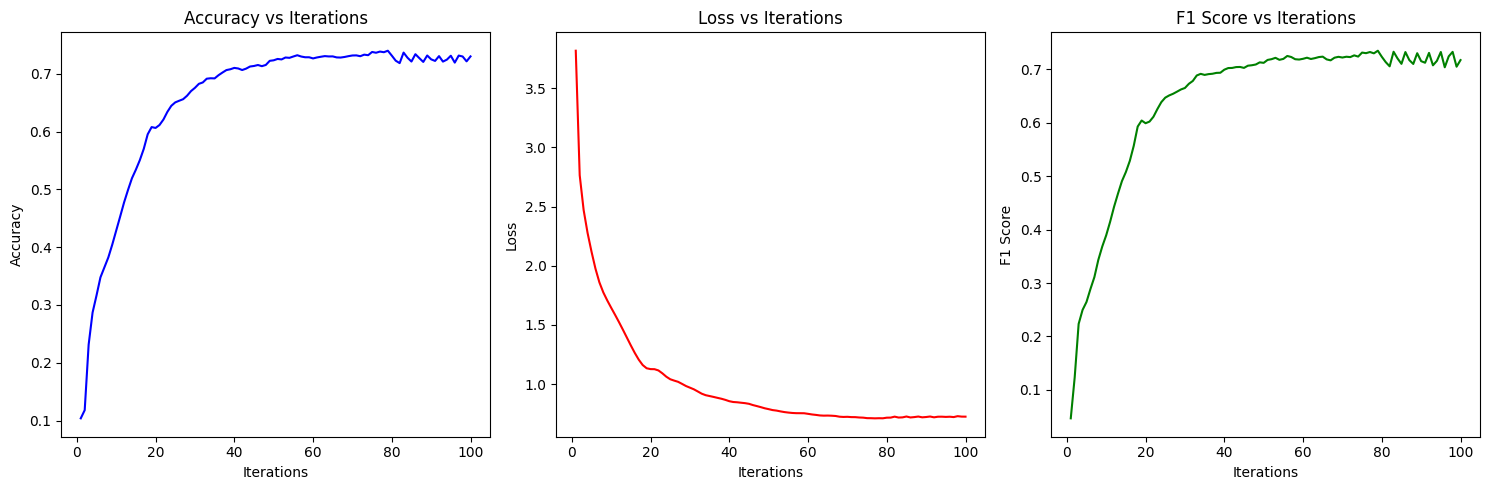

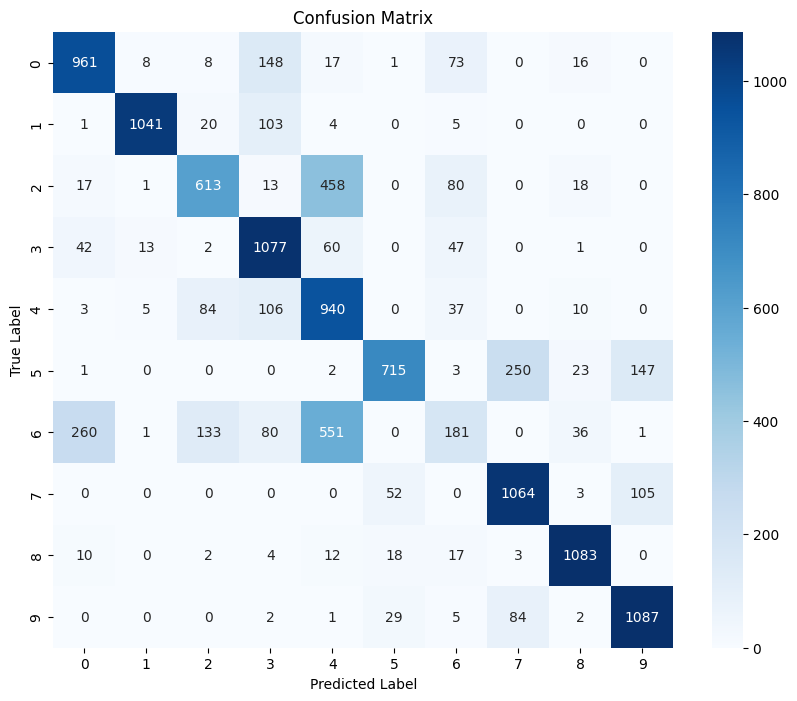

In [142]:
nn1.train_and_record_metrics(X_train,Y_train,X_valid,Y_valid,100)

In [6]:
nn2 = NeuralNetwork(784,50,10,0.01)


0.8253333333333334 0.4997655273992343 0.8239203073197283


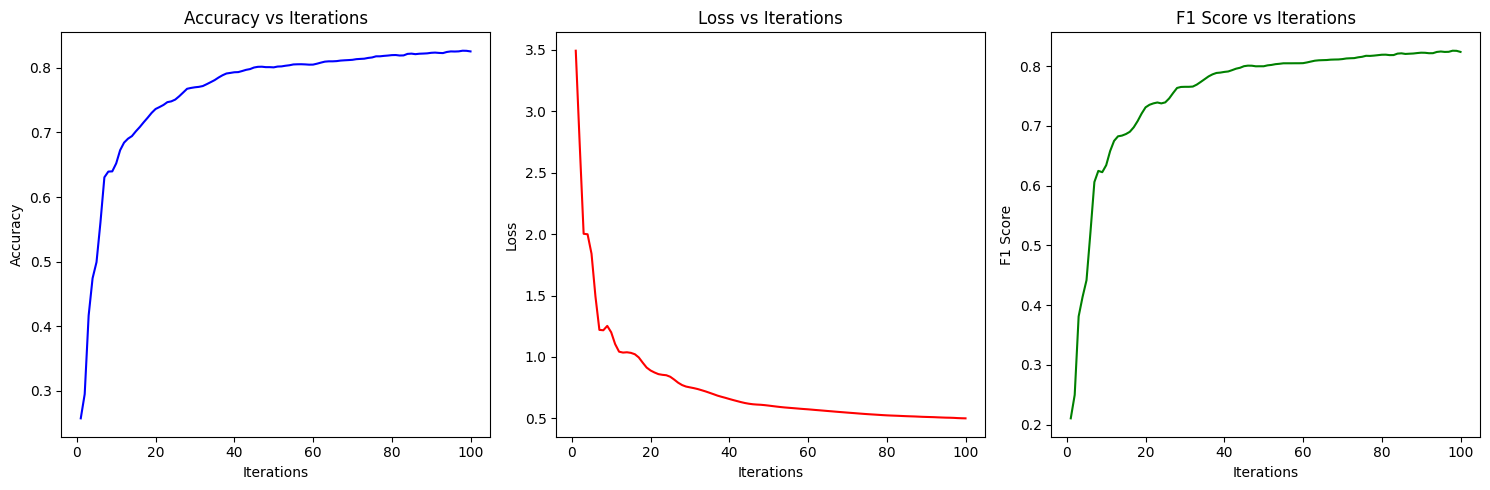

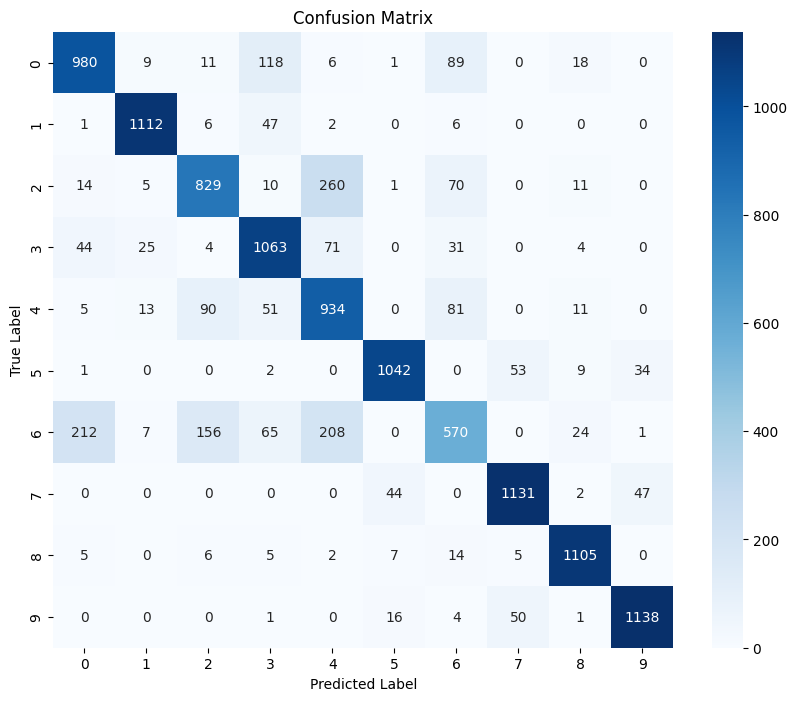

In [7]:
nn2.train_and_record_metrics(X_train,Y_train,X_valid,Y_valid,100)

In [8]:
nn3 = NeuralNetwork(784,100,10,0.01)

0.8418333333333333 0.45594560923850924 0.8400568881152857


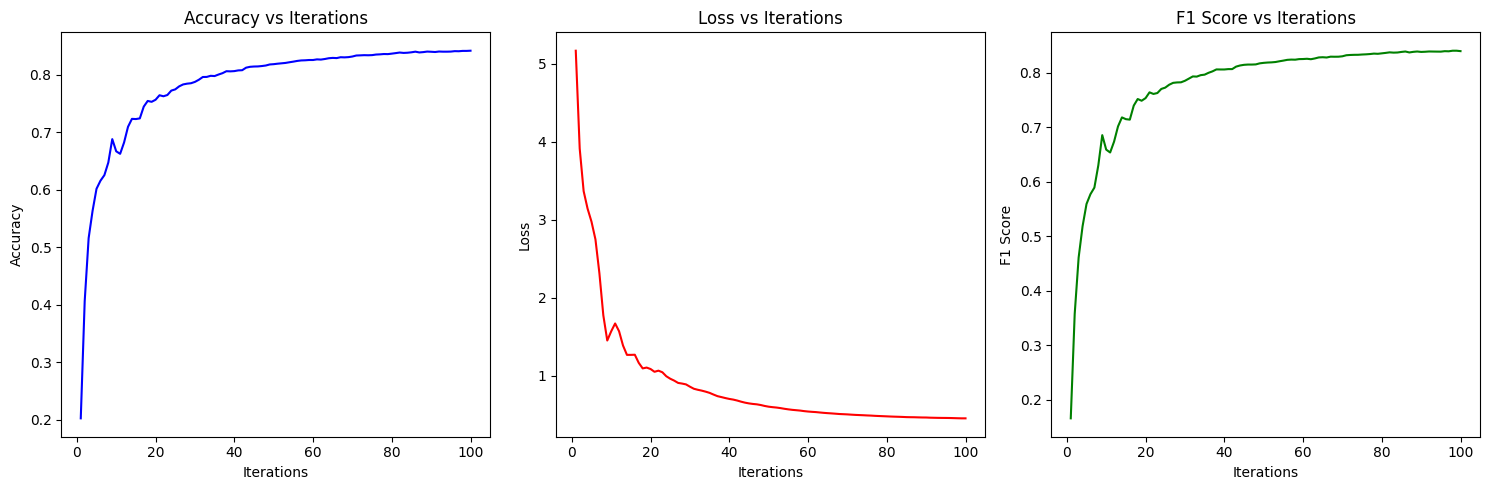

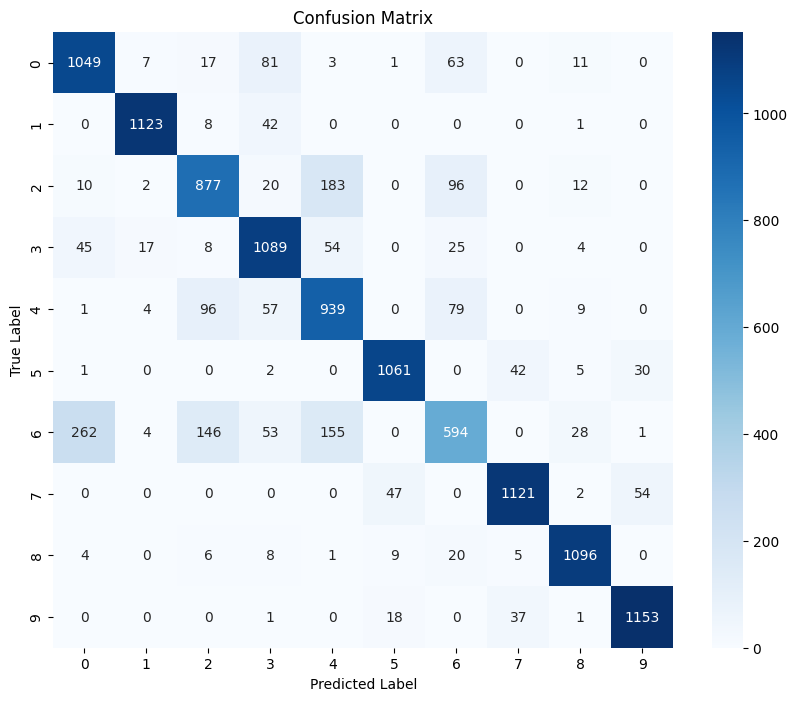

In [9]:
nn3.train_and_record_metrics(X_train,Y_train,X_valid,Y_valid,100)

In [4]:
import pickle

# Initialize and train the neural network
nn = NeuralNetwork(784, 100, 10, 0.01)
nn.gradient_descent(X_train, Y_train, 1000)

# Save the trained model
with open('model_1905092.pkl', 'wb') as f:
    pickle.dump(nn, f)



In [5]:

# Load the trained model
with open('model_1905092.pkl', 'rb') as f:
    loaded_nn = pickle.load(f)  # Use pickle.load, not pickle.dump

# Make predictions using the loaded model
test_predictions = loaded_nn.make_predictions(X_test)
acc = loaded_nn.get_accuracy(test_predictions,Y_test)
print(acc)

0.8842
